# Notebook Feux Danois

Dans cette partie nous éudierons un jeu de données correspondant aux feux de forets Danois entre 1980 et 1990

In [2]:
rm(list = ls())   # erase everything, start from scratch!
library(evir)
library(lubridate)
data(danish)


#??date
# summary(danish)
#danish


Warning message:
"package 'lubridate' was built under R version 4.0.5"

Attaching package: 'lubridate'


The following objects are masked from 'package:base':

    date, intersect, setdiff, union




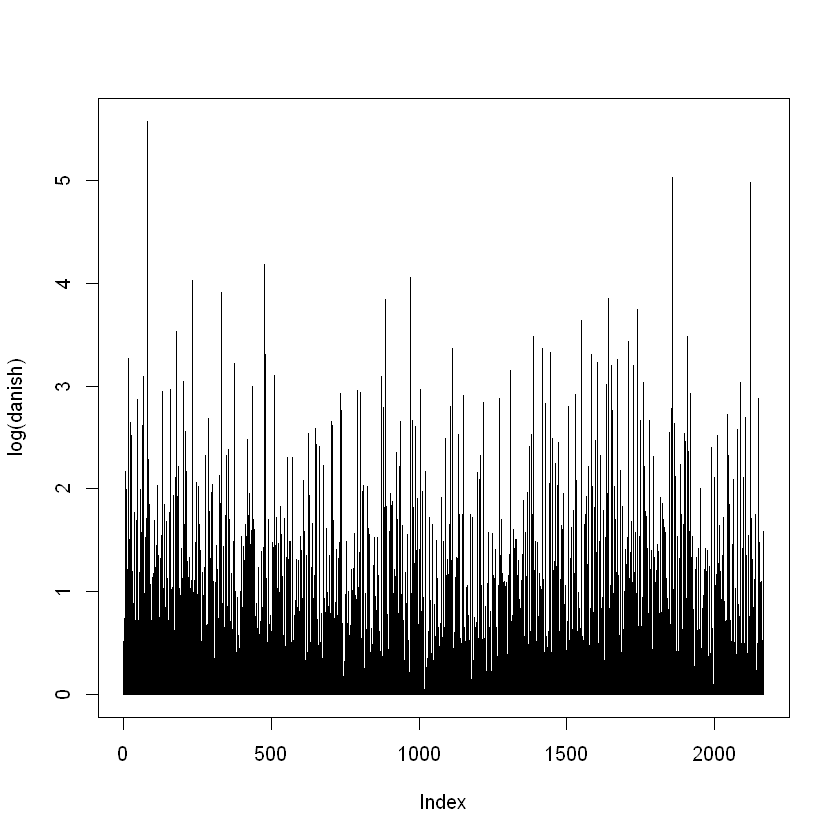

In [3]:
plot(log(danish),type ="h")

In [4]:
temps=attributes(danish)$times
df= data.frame (danish)
time.interval <- temps[0:2166] %--% temps[2 :  2167]

time.duration <- as.duration(time.interval)
Time= as.numeric (time.duration, "days")


In [5]:
N_T= cumsum(Time)
Lamb=length(N_T)/N_T[length(N_T)]
print (Lamb)

[1] 0.539477


Si on suppose que le processus de comptage suit le processus de Poisson, lambda estimé par 0.5.
On a à peu près 1 claim tous les deux jours.

On veut s'assurer que ce processus suit bien une loi de Poisson. Il faut que les Wi soient des exponentielles iid de param (1/lmbda)

#### Test sur la loi des W_t

In [9]:
#Code pas très optimal mais permets de créer des Wt ou il n'y a plus de zéro

N=length (Time)
Time2=Time
for (i in (2:N-1)){
      if (Time[i]==0 & Time [i+1]!=0 )
      {Time2[i]=0.5} 
    else if (Time[i]==0 & Time [i+1]==0 )
    {Time2[i]=0.3
        Time2[i+1]=0.3}  
}

In [10]:
# Les test avec Time 2: Ks test ne change pas LcKs un peu meilleur mais reste petit (0.001)
library(KScorrect)

ks.test(Time2,"pexp")

Lc <- LcKS(Time2,cdf="pexp",nreps=999)
Lc$p.value

Warning message in ks.test(Time2, "pexp"):
"ties should not be present for the Kolmogorov-Smirnov test"



	One-sample Kolmogorov-Smirnov test

data:  Time2
D = 0.39112, p-value < 2.2e-16
alternative hypothesis: two-sided


[1] 0.001

In [9]:
mu1= mean (Time) #pour s'assurer qu'on retrouve bien Lamb=1/mu1

ks.test(Time,"pexp",1/mu1)
#ks.exp.test(Time)#,"pexp",lambda=1/mu1)

Warning message in ks.test(Time, "pexp", 1/mu1):
“ties should not be present for the Kolmogorov-Smirnov test”



	One-sample Kolmogorov-Smirnov test

data:  Time
D = 0.241, p-value < 2.2e-16
alternative hypothesis: two-sided


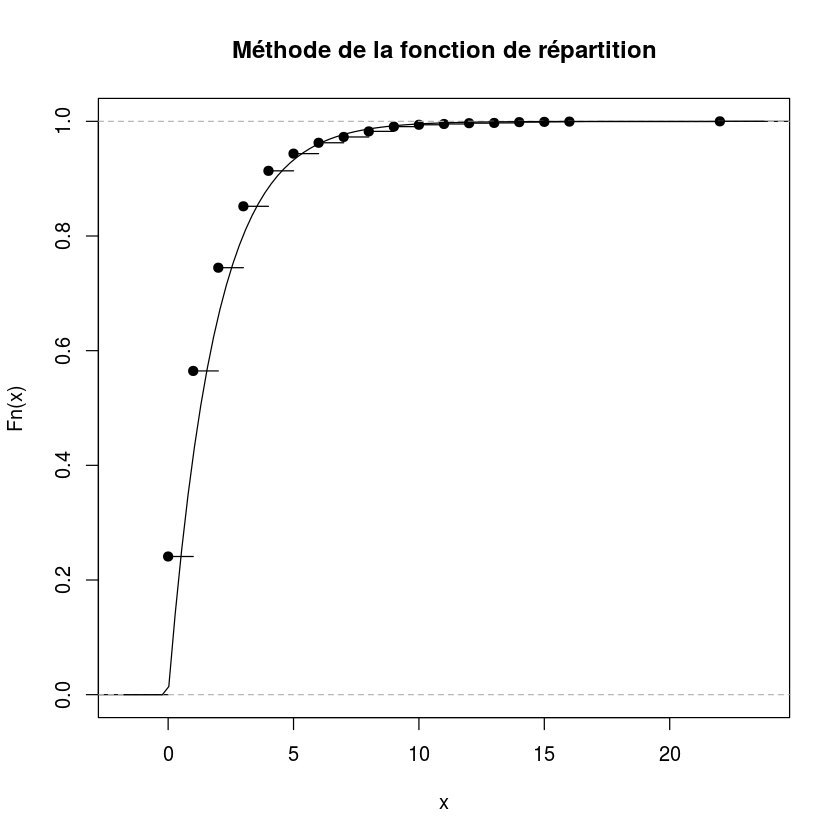

In [10]:
###  Methode en affichant la fdr empirique

plot(ecdf(Time), main = "Méthode de la fonction de répartition")
curve(pexp(x, 1/mu1), add = TRUE)


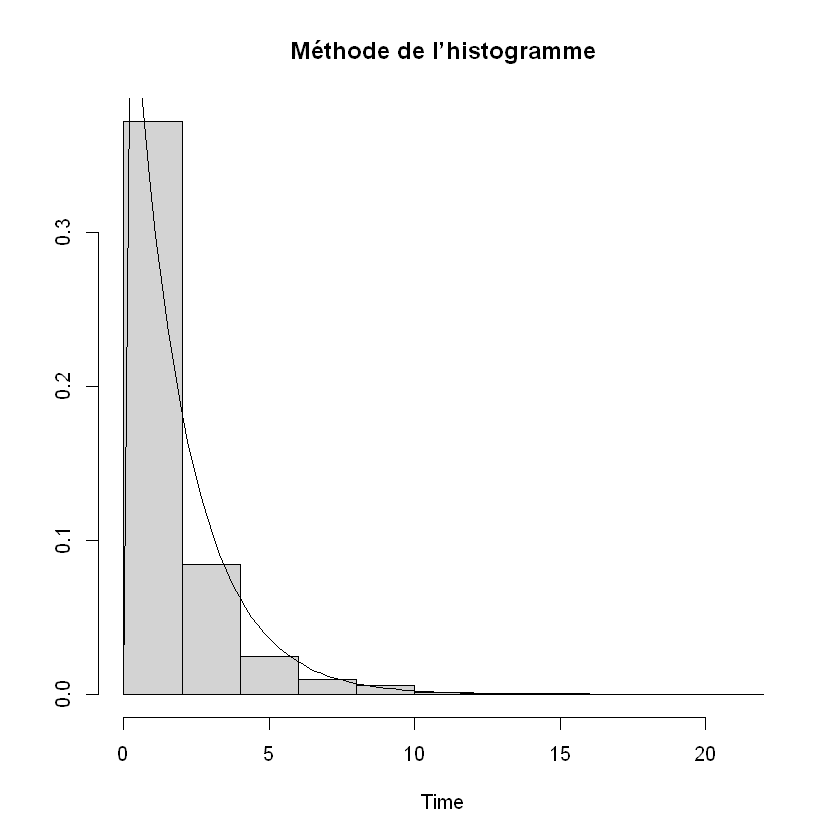

In [6]:
###  Version en affichant les histogrammes empirique
hist(Time, freq = FALSE, main = "Méthode de l’histogramme", ylab = "")
curve(dexp(x, 1/mu1), add = TRUE)

On est dans le cas Large claims, on commence par observer les données et estimer lambda

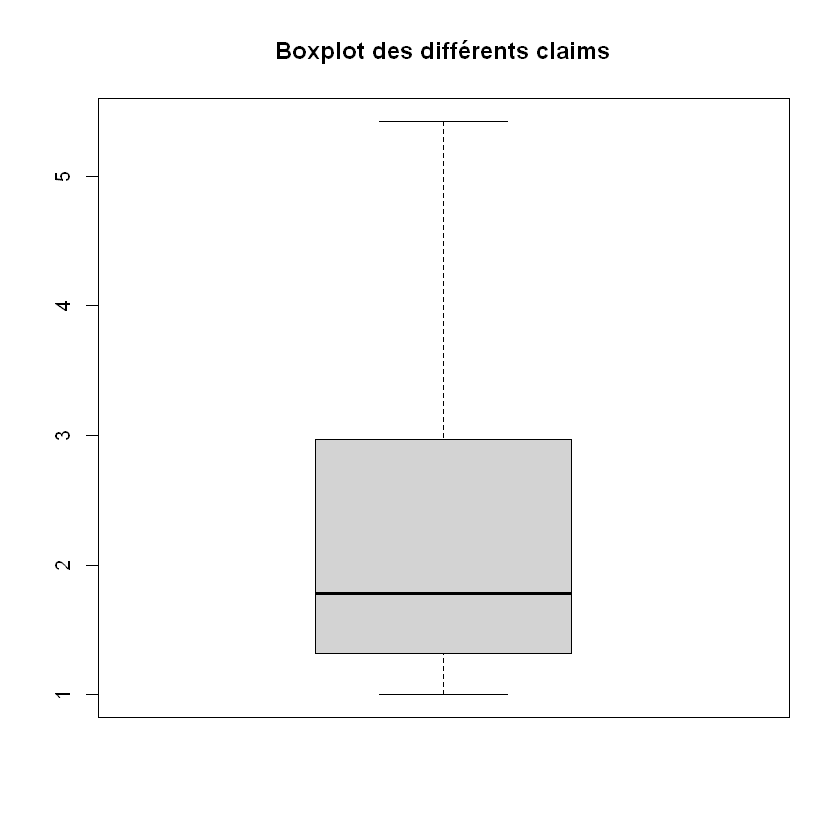

In [7]:
boxplot(danish,main="Boxplot des différents claims",outline=FALSE)
#Calcul de la moyenne et ecart type de X
mu=mean(danish)
sigma= sd(danish)


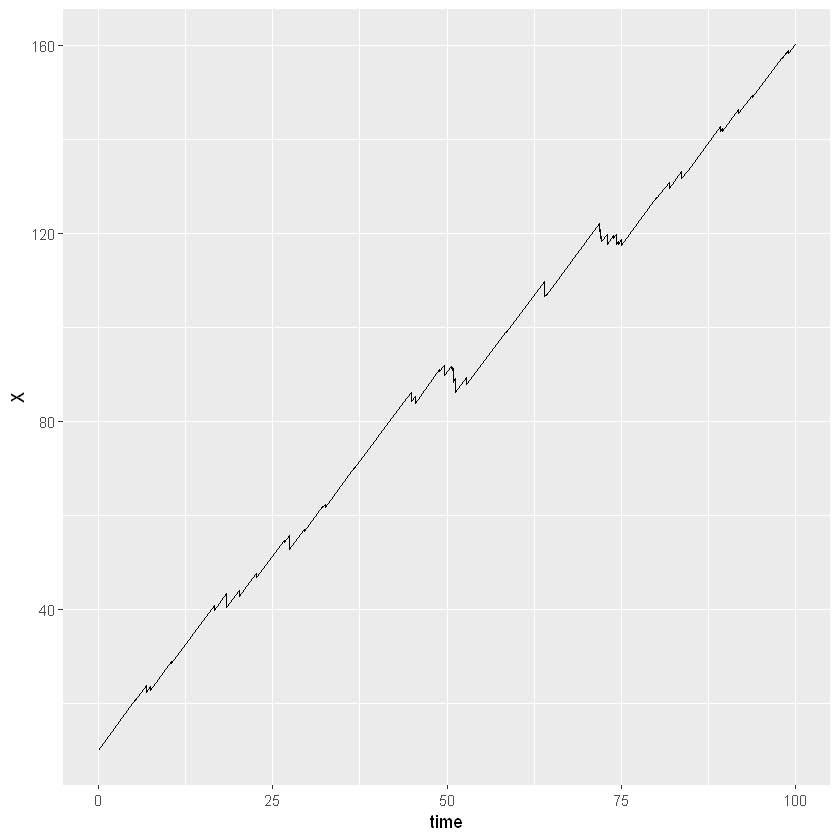

In [16]:
###  Il y'a possibilté de génerer directement le modèle CL avec le packge ruin
library(ruin)


model <- CramerLundberg(initial_capital = 10,
premium_rate = 2,
claim_poisson_arrival_rate = Lamb,
claim_size_generator = rexp,
claim_size_parameters = list(rate = 1))
path <- simulate_path(model = model, max_time_horizon = 100)
plot_path(path)